In [67]:
import itertools
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pandas as pd
import os
import io
import re
import sys
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [25]:
processed_path = '../data/CSE-CIC-IDS2018/processed'
cleaned_csv_files = [
  '02-14-2018-bruteforce-ftp-ssh.csv',
  '02-15-2018-dos-goldeneye-slowloris.csv',
  '02-16-2018-dos-slowhttp-hulk.csv',
  '02-21-2018-ddos-loic-udp.csv',
  '02-22-2018-bruteforce-webxss.csv',
  '02-23-2018-bruteforce-webxss-sql.csv',
  '02-28-2018-infiltration.csv',
  '03-01-2018-botnet.csv',
  '03-02-2018-infiltration.csv'
  #'02-20-2018-ddos-loic-tcp.csv'   # WARNING: 4GB FILE.
]

list_of_dataframes = []
for filename in cleaned_csv_files:
    fname = os.path.join(processed_path, filename)
    list_of_dataframes.append(pd.read_csv(fname))

IDS_df = pd.concat(list_of_dataframes)

KeyboardInterrupt: 

In [26]:
IDS_df = pd.read_csv("../data/CSE-CIC-IDS2018/IDS-2018-multiclass.csv")

# To display the top 5 rows/
# IDS_df.head(5)
IDS_df.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
      

In [27]:
IDS_df = IDS_df.drop('timestamp', axis=1)

In [28]:
for i in range(len(IDS_df.columns)):
     print(IDS_df.columns[i], '-', IDS_df.dtypes[i])

dst_port - int64
protocol - int64
flow_duration - int64
tot_fwd_pkts - int64
tot_bwd_pkts - int64
totlen_fwd_pkts - float64
totlen_bwd_pkts - float64
fwd_pkt_len_max - float64
fwd_pkt_len_min - float64
fwd_pkt_len_mean - float64
fwd_pkt_len_std - float64
bwd_pkt_len_max - float64
bwd_pkt_len_min - float64
bwd_pkt_len_mean - float64
bwd_pkt_len_std - float64
flow_byts_s - float64
flow_pkts_s - float64
flow_iat_mean - float64
flow_iat_std - float64
flow_iat_max - float64
flow_iat_min - float64
fwd_iat_tot - float64
fwd_iat_mean - float64
fwd_iat_std - float64
fwd_iat_max - float64
fwd_iat_min - float64
bwd_iat_tot - float64
bwd_iat_mean - float64
bwd_iat_std - float64
bwd_iat_max - float64
bwd_iat_min - float64
fwd_psh_flags - int64
bwd_psh_flags - int64
fwd_urg_flags - int64
bwd_urg_flags - int64
fwd_header_len - int64
bwd_header_len - int64
fwd_pkts_s - float64
bwd_pkts_s - float64
pkt_len_min - float64
pkt_len_max - float64
pkt_len_mean - float64
pkt_len_std - float64
pkt_len_var - fl

In [29]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(413648, 79)


In [30]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

1900


In [31]:
#  first replace infs to NaN:
IDS_df = IDS_df.replace([np.inf, -np.inf], np.nan)

In [32]:
# print shape after dropping NaN rows
IDS_df = IDS_df.dropna()
print(IDS_df.shape)
IDS_df = IDS_df.reset_index(drop=True)

(412698, 79)


In [33]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


Examine the proportion of types of traffic:

In [34]:
IDS_df['label'].value_counts()

Benign                      199275
Infilteration                39777
DDoS attacks-LOIC-HTTP       20000
DoS attacks-Hulk             20000
DoS attacks-GoldenEye        20000
SSH-Bruteforce               20000
Bot                          20000
DDOS attack-HOIC             20000
DoS attacks-SlowHTTPTest     20000
FTP-BruteForce               19998
DoS attacks-Slowloris        10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web               611
Brute Force -XSS               230
SQL Injection                   87
Name: label, dtype: int64

In [35]:
label_names = np.unique(IDS_df["label"])
label_names

array(['Benign', 'Bot', 'Brute Force -Web', 'Brute Force -XSS',
       'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP',
       'DDoS attacks-LOIC-HTTP', 'DoS attacks-GoldenEye',
       'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest',
       'DoS attacks-Slowloris', 'FTP-BruteForce', 'Infilteration',
       'SQL Injection', 'SSH-Bruteforce'], dtype=object)

Convert all non-normal observations into a single class:

In [37]:
def get_label(text):    
    if text == "Benign":
        return 0
    elif text == 'Infilteration':
        return 1
    elif text == 'DoS attacks-Slowloris':
        return 2
    elif text == 'SSH-Bruteforce':
        return 3
    elif text == 'DDOS attack-HOIC':
        return 4
    elif text == 'FTP-BruteForce':
        return 5
    elif text == 'DoS attacks-SlowHTTPTest':
        return 6
    elif text == 'Bot':
        return 7
    elif text == 'DoS attacks-Hulk':
        return 8
    elif text == 'DoS attacks-GoldenEye':
        return 9
    elif text == 'DDoS attacks-LOIC-HTTP':
        return 10
    elif text == 'DDOS attack-LOIC-UDP':
        return 11
    elif text == 'Brute Force -Web':
        return 12
    elif text == 'Brute Force -XSS':
        return 13
    elif text == 'SQL Injection':
        return 14

IDS_df["label"] = IDS_df["label"].apply(get_label)

In [38]:
#y = IDS_df["Label"].values
print(IDS_df["label"].value_counts())

0     199275
1      39777
10     20000
9      20000
8      20000
7      20000
6      20000
4      20000
3      20000
5      19998
2      10990
11      1730
12       611
13       230
14        87
Name: label, dtype: int64


Convert all categorical features into numerical form:

In [39]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in IDS_df.columns:
    if IDS_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        IDS_df[c] = encodings_dictionary[c].fit_transform(IDS_df[c])

Use Stratified K Fold to split the data into train and validation

In [68]:
seed = 1234
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state = seed)
target = IDS_df.loc[:,'label']

Train-test split the dataset:

In [69]:
def GetPyTorchDataLoaders(x_train, x_test, y_train, y_test, batch_size = 1000):
    # Pytorch
    X_train  = torch.from_numpy(x_train).float()
    Y_train = torch.from_numpy(y_train)

    X_test = torch.from_numpy(x_test).float()
    Y_test = torch.from_numpy(y_test)

    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(X_train, Y_train)
    valid = torch.utils.data.TensorDataset(X_test, Y_test)

    # data loader
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

    print('Completed loading data and returning pytorch train and validation data loaders')
    return train_loader, valid_loader

In [99]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
        
print(device)

# Defining the DNN model
#input_size = train_loader.dataset.tensors[0].shape[1]
input_size = 78
hidden_layers = [256]
output_size = 15

# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(n_inputs, hidden_layers[0])
        self.activ1 = nn.ReLU()
        
        #self.layer2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        #self.activ2 = nn.ReLU()

        #self.layer3 = nn.Linear(hidden_layers[1], hidden_layers[2])
        #self.activ3 = nn.ReLU()
        
        self.layer2 = nn.Linear(hidden_layers[0], output_size)
        
    # forward propagate input
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        
        #x = self.layer2(x)
        #x = self.activ2(x)
        
        #x = self.layer3(x)
        #x = self.activ3(x)
        
        x = self.layer2(x)
        return x

model = MLP(input_size)
print(model)
model.to(device)

 # Cross Entropy Loss 
error = nn.CrossEntropyLoss().to(device)
# Adam Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

cpu
MLP(
  (layer1): Linear(in_features=78, out_features=256, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=256, out_features=15, bias=True)
)


In [98]:
 def plot_confusion_matrix(conf_matrix, label_names):
        '''Plot confusion matrix
        # param conf_matrix: confusion matrix nd array
        # return: None
        '''
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.9)
        # show all ticks
        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        # label them with the respective list entries
        ax.set_xticklabels(label_names,  rotation=45)
        ax.set_yticklabels(label_names)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i, s=conf_matrix[i,j], va='center', ha='center')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

In [96]:
def train_model(train, test, fold_no):
    print('Start training...')
    start_time = time.time()

    epochs = 1

    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    accuracy_scores = []
    
    # Separate into training data and labels, testing data and labels
    Y_train = train.pop("label").values
    X_train = train.values
    
    Y_test = test.pop("label").values
    X_test = test.values
    
    # Get PyTorch training and validation data loaders
    train_loader, valid_loader = GetPyTorchDataLoaders(X_train, X_test, Y_train, Y_test, batch_size = 1000)

    for e in range(epochs):
        correct_epoch = 0
        total_epoch = 0
        for i, (data, labels) in enumerate(train_loader):
            train = data.to(device)
            labels = labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            if count % 100 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0

                # Iterate through test dataset
                for data, labels in valid_loader:
                    valid = data.to(device)                               
                    labels = labels.to(device)

                    # Forward propagation
                    outputs = model(valid)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    #print('Predicted: ', predicted)

                    # Total number of labels
                    total += len(labels)
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                
            if count % 100 == 0:
                # Print Loss
                print('Epoch: {} Iteration: {}  Loss: {}  Accuracy: {} %'.format(e + 1, count, loss.data, accuracy))

            count += 1
        
        all_preds = torch.LongTensor([]).to(device)
        
        # calculate accuracy on the validation set
        # Iterate through test dataset
        for data, labels in valid_loader:
            valid = data.to(device)                               
            labels = labels.to(device)

            # Forward propagation
            outputs = model(valid)

            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            all_preds = torch.cat(
                (all_preds, predicted),
                dim =0
            )
            
            total_epoch += len(labels)
            correct_epoch += (predicted == labels).sum()

        accuracy_epoch = (100 * correct_epoch / float(total_epoch)).item()

        print('Fold',str(fold_no), 'Epoch No. :', e, 'Accuracy for Epoch :', accuracy_epoch)

    end_time = time.time()
    accuracy_scores.append(accuracy_epoch)
    mean_accuracy_score = np.mean(accuracy_scores)
    print('Epochs completed. Time taken (seconds): ', str(end_time - start_time))
    print('Average accuracy over all epochs', mean_accuracy_score)
    
    print(all_preds.size())
    all_preds_np = all_preds.cpu().data.numpy()
    print(all_preds_np.shape)
    
    # print the confusion matrix for this epoch and fold
    print('Plotting confusion matrix for fold :' , fold_no)
    cnf_matrix = confusion_matrix(all_preds_np, Y_test)
    plot_confusion_matrix(cnf_matrix, label_names)
    #plt.show()
    return mean_accuracy_score
   

Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 9840.0244140625  Accuracy: 72.75247192382812 %
Epoch: 1 Iteration: 100  Loss: 8860.8623046875  Accuracy: 72.37592315673828 %
Epoch: 1 Iteration: 200  Loss: 6578.92431640625  Accuracy: 80.4525375366211 %
Fold 1 Epoch No. : 0 Accuracy for Epoch : 67.23802947998047
Epochs completed. Time taken (seconds):  13.39904499053955
Average accuracy over all epochs 67.23802947998047
torch.Size([206349])
(206349,)
Plotting confusion matrix for fold : 1


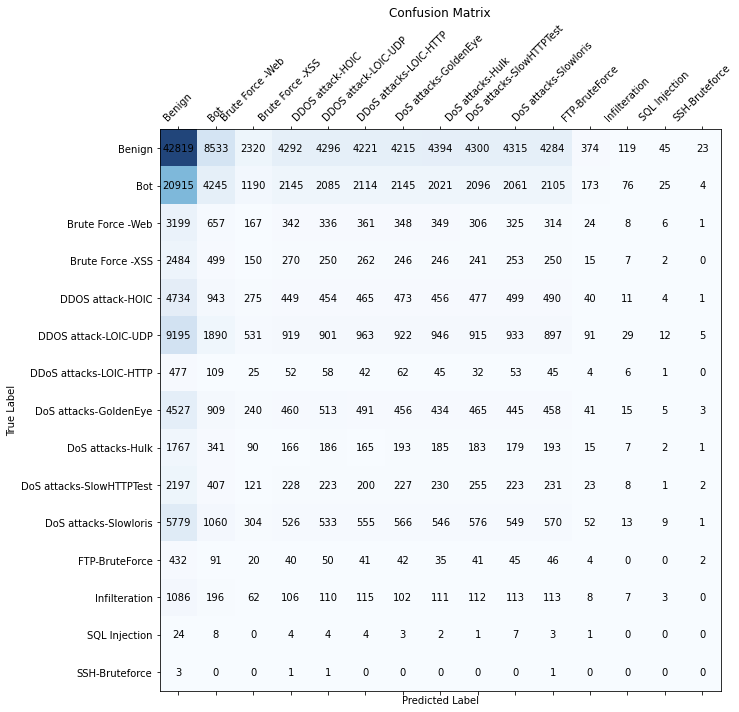

Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 3635.350830078125  Accuracy: 72.90609741210938 %
Epoch: 1 Iteration: 100  Loss: 7930.5947265625  Accuracy: 69.9034194946289 %
Epoch: 1 Iteration: 200  Loss: 6288.28466796875  Accuracy: 79.96016693115234 %
Fold 2 Epoch No. : 0 Accuracy for Epoch : 67.42508697509766
Epochs completed. Time taken (seconds):  13.532673835754395
Average accuracy over all epochs 67.42508697509766
torch.Size([206349])
(206349,)
Plotting confusion matrix for fold : 2


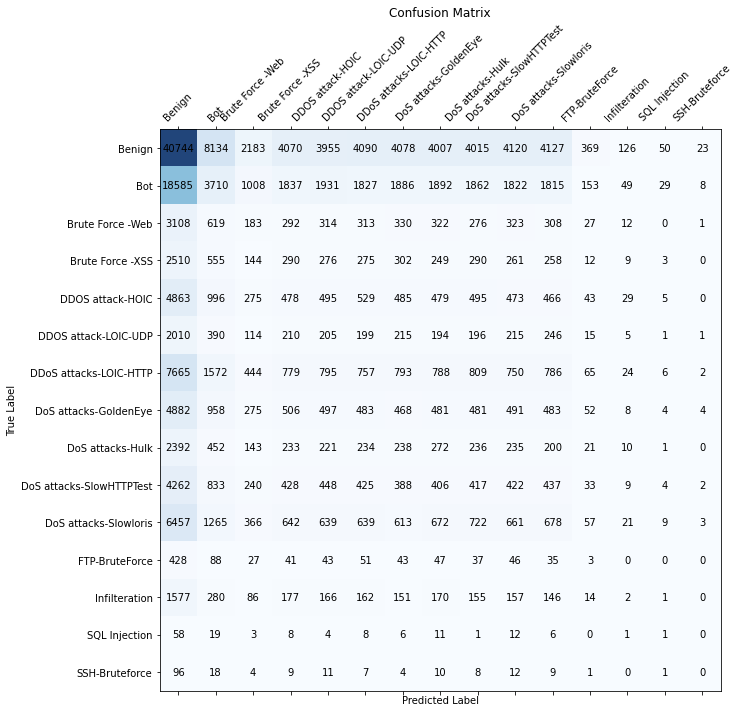

Mean accuracy score across all cross validation sets 67.33155822753906


In [97]:
accuracy_scores = []
fold_no = 1

for train_index, test_index in skf.split(IDS_df, target):
    train = IDS_df.loc[train_index,:]
    test = IDS_df.loc[test_index,:]
    accuracy_score = train_model(train, test, fold_no)
    accuracy_scores.append(accuracy_score)
    fold_no += 1
    
print('Mean accuracy score across all cross validation sets', np.mean(accuracy_scores))

In [19]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.show()

NameError: name 'iteration_list' is not defined